**Reporte de Selección de modelos y parámetros**

Robert Lopez,
Diego Monroy,
Cesar Porras,
Laura Becerra

#### Cargue información y paquetes necesarios

In [ ]:
!pip install pandasql
import seaborn as sns
import pandas as pd
import numpy as np
from pandasql import sqldf
run_query = lambda query: sqldf(query, globals())
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min,silhouette_score
from sklearn.mixture import GaussianMixture
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import warnings
from tabulate import tabulate
warnings.filterwarnings("ignore")
from sklearn.cluster import DBSCAN
from sklearn import metrics

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26771 sha256=689303bf68735e12e54dc5669ec018af56c08f8c65ee3e8e1ac84915d37807c0
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.7 MB/s eta 0:00:00


In [ ]:
base_compras = pd.read_csv("/content/sample_data/BAQ_compras.csv")
sipsa = pd.read_csv("/content/sample_data/sipsa.csv")
base_productos = pd.read_csv("/content/sample_data/Products_BAQ.csv")

## Planteamiento requerimientos de negocio

El entregable propuesto a Frubana consta de dos elementos:

*   Un elemento de visualización y caracterización de cada uno de los proveedores de acuerdo a la información disponible  
*   Un elemento de agrupamiento y clasificación de proveedores de acuerdo a la información disponible

Para el elemento de visualización y caracterización, resulta conveniente de hacer uso de métodos descriptivos en dos escalas: Una escala absoluta y una escala temporal. La estimación de promedios, portafolios de productos y acumulado de pedidos permite realizar una caracterización de las capacidades productivas del proveedor, mientras que una evaluación a nivel temporal permite evidenciar la evolución de indicadores estratégicos que evalúen la relación comercial con los distintos proveedores.

Las métricas seleccionadas para evaluar con un corte transversal son el volumen de pedidos atendidos, el volumen de productos ofrecidos, el volumen de productos con perfiles de descomposición distintos (importante para análisis de temas de logística de almacenamiento), así como el pedido máximo y el pedido mínimo histórico que puede suplir dicho proveedor.

La métrica seleccionada para evidenciar la evolución histórica de la relación con el proveedor, así como el impacto económico de la selección de proveedores, es la diferencia porcentual del precio de compra por unidad con el precio por unidad reportado por el SIPSA (Sistema de Información de Precios y Abastecimiento del Sector Agropecuario) Dicha información se construyó realizando una estandarización de los nombres de producto y los nombres reportados en las bases de Frubana, y posteriormente realizando un cruce por fecha de compra y nombre entre ambas bases. Para esta métrica, cabe destacar que para ciertos productos nativos de las regiones (Como por ejemplo el níspero o el agraz), no se encuentra información en el SIPSA, por lo que se estimó una diferencia de 0 entre el valor de mercado y el valor del proveedor. Sin embargo, para el desarrollo final se propone una búsqueda más completa en otras bases de precios con el fin de obtener la información completa

En el caso de las métricas de agrupamiento y clasificación, al no existir una clasificación en Frubana, se hará uso de modelos predictivos de tipo clustering, con el fin de observar agrupaciones entre los datos por similitud, así como distinguir las principales características que definen a estos grupos en función de la información existente dentro de las bases de datos. Ya que corresponde a una primer aproximación de los grupos, se realizará con un corte transversal, y en el caso de la métrica de diferencia porcentual de precios se hará un promedio del corte histórico hasta la fecha. En este caso puntual debe tenerse cuidado con el análisis de dicho valor para los productos de los que no se posee información al interior del SIPSA, ya que puede sugerirse seguir con un proveedor por desinformación mas no por conveniencia para Frubana

## Alternativas para el problema de clasificación y agrupamiento

Para solucionar el problema de clasificación y agrupamiento, se realizará una evaluación de los métodos más comunes de clustering:

*   K-medias
*   Clustering jerárquico
*   DBScan
*   Gaussian Mixture Model (GMM)
*   K-medioides

Estos métodos cuentan con la ventaja de ser de fácil implementación, además de permitir una caracterización inicial de los proveedores, el cual es el objetivo de esta primer etapa. Como desventaja, necesitan una recalibración frecuente tanto con la entrada de nuevos proveedores como con la actualización de información histórica de los proveedores actuales. Sin embargo, con esta primer aproximación se puede generar un grupo de categorías y características fijas, y posteriormente utilizar métodos más robustos de clasificación (Como redes neuronales), que permitan clasificar con mayor detalle cada uno de los métodos planteados

También cabe destacar que en esta primera etapa, al ser una base de datos de un tamaño pequeño (141 proveedores con 6 características), no se considera necesario realizar una reducción de dimensionalidad de las características. En caso de en un futuro agregarse más características, se recomienda primero realizar un algoritmo de reducción de dimensionalidad como PCA y luego realizar dicho agrupamiento, aunque esto puede reducir la interpretabilidad de los factores que contribuyen al agrupamiento buscado


## Verificación de supuestos y preparación de datos para algoritmos de clustering

Los algoritmos de clustering no requieren una preparación rigurosa de la base de datos, en este caso sólo requieren que se utilicen variables numéricas (para el cálculo de distancias), así como que no se cuente con información faltante) A continuación se presenta la base de datos de los 140 proveedores disponibles, junto con las variables utilizadas para la clasificación. Como puede observarse, no se cuentan con datos faltantes o fuera de formato, por lo que puede procederse con la clasificación

In [ ]:
query_1 = """
SELECT a.*,b.Diff as Prom_variacion_sipsa
from (SELECT bc.supplier_id as Proveedor,
count(distinct bc.id) as Pedidos_atendidos,
count(distinct bc.name) as Volumen_portafolio,
count(distinct bp.category) as Volumen_category_portafolio,
min(bc.quantity) as Minimo_pedido,
max(bc.quantity) as Maximo_pedido
from base_compras bc
left join base_productos bp on bc.product_id = bp.product_id
group by supplier_id) a
left join sipsa b on (a.Proveedor = b.Id)
;
"""
result_1 = run_query(query_1)
print(result_1)

     Proveedor  Pedidos_atendidos  Volumen_portafolio  \
0            2                330                  23   
1            3                  2                   2   
2            9                 34                   4   
3           10                 30                  17   
4           18                 98                   9   
..         ...                ...                 ...   
136       6208                  2                   1   
137       6220                  4                   1   
138       6234                  4                   2   
139       6237                  2                   2   
140       6273                  1                   1   

     Volumen_category_portafolio  Minimo_pedido  Maximo_pedido  \
0                              2            1.0          100.0   
1                              1           15.0           20.0   
2                              1            1.0          160.0   
3                              1            1.0    

## Calibración y selección de modelos

Para cada uno de los modelos, se realizó una evaluación en grid, la cual permite modificar los hiperparámetros del modelo para optimizar la métrica de rendimiento.

Para evaluar la calidad de los clusters obtenidos, se utilizará como criterio el coeficiente de Silhouette, el cual permite ponderar la distancia de los elementos dentro del cluster con la distancia de los elementos al cluster más próximo, dando una medida tanto de clasificación correcta como de superposición de los clusters.

En este caso particular como corresponde a una clasificación inicial de todos los proveedores, se realizará la evaluación sobre toda la muestra.

Finalmente, adicional al criterio del coeficiente de Silhouette, se realizará una evaluación de viabilidad técnica y conceptual, para determinar si cada modelo posee particularidades específicas que lo hacen más conveniente para el problema a solucionar, así posea un desempeño en clustering ligeramente inferior

### K-means

En el algoritmo de k-medias, para calibrar el número óptimo de clusters, se usa el método del codo gráfico. En este caso, se observa una inflexión cercana a los 5 clusters, por lo que este será el valor utilizado para compararlo frente a los demás métodos

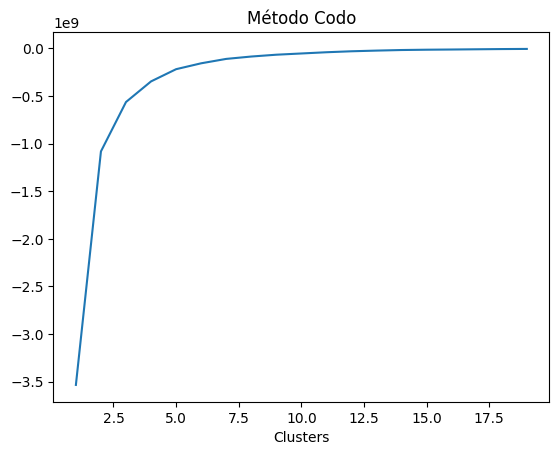

In [ ]:
X = result_1.drop(columns = ['Proveedor'])
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Clusters')
plt.title('Método Codo')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=5).fit(X)
sil_kmeans = silhouette_score(X, kmeans.fit_predict(X))

In [ ]:
result_1['Cluster'] = kmeans.predict(X)
result_1

,Proveedor,Pedidos_atendidos,Volumen_portafolio,Volumen_category_portafolio,Minimo_pedido,Maximo_pedido,Prom_variacion_sipsa,Cluster
0,2,330,23,2,1.0,100.0,-0.080710,0
1,3,2,2,1,15.0,20.0,0.000000,0
2,9,34,4,1,1.0,160.0,0.027052,0
3,10,30,17,1,1.0,159.0,-0.103380,0
4,18,98,9,1,5.0,742.0,0.122707,0
...,...,...,...,...,...,...,...,...
136,6208,2,1,1,200.0,500.0,0.000000,0
137,6220,4,1,1,760.0,2140.0,-0.164336,0
138,6234,4,2,2,200.0,1000.0,-0.043578,0
139,6237,2,2,1,12.0,43.0,-0.113687,0


In [ ]:
centroids = kmeans.cluster_centers_
pd.
print(centroids)

[[ 3.43145161e+01  4.53225806e+00  1.31451613e+00  1.41126613e+02
   6.49870968e+02  6.27589274e-04]
 [ 5.70000000e+01  2.50000000e+00  2.00000000e+00  5.74000000e+02
   2.85000000e+04  2.10677000e-03]
 [ 8.88750000e+01  2.12500000e+01  2.37500000e+00  8.35000000e+01
   1.15527500e+04  5.72534813e-02]
 [ 8.50000000e+00  1.00000000e+00  1.00000000e+00  7.70000000e+03
   1.69120000e+04  0.00000000e+00]
 [ 1.20000000e+00  1.00000000e+00  1.00000000e+00  7.44560000e+03
   7.44560000e+03 -4.33680869e-19]]


In [ ]:
result_1.to_csv("datos_con_clusters.csv")
centroids.to_csv("caracterizacion_centroides.csv")

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

### Jerárquico

En el caso del algoritmo jerárquico, se evaluán todos los posibles métodos de agrupamiento (Sencillo, completo, promedio, Ward), y se selecciona el que posea un mayor desempeño. Los resultados de cada uno de los modelos se observan a continuación

In [ ]:

linkage_data1 = linkage(X, method='single', metric='euclidean')
linkage_data2 = linkage(X, method='complete', metric='euclidean')
linkage_data3 = linkage(X, method='average', metric='euclidean')
linkage_data4 = linkage(X, method='ward', metric='euclidean')

hierarchical_cluster1 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')
hierarchical_cluster2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
hierarchical_cluster3 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='average')
hierarchical_cluster4 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')

sil_1 = silhouette_score(X, hierarchical_cluster1.fit_predict(X))
sil_2 = silhouette_score(X, hierarchical_cluster2.fit_predict(X))
sil_3 = silhouette_score(X, hierarchical_cluster3.fit_predict(X))
sil_4 = silhouette_score(X, hierarchical_cluster4.fit_predict(X))

data = [['Single', sil_1, 2],
['Complete', sil_2, 2],
['Average', sil_3, 2],
['Ward', sil_4, 2]]

print (tabulate(data, headers=["Método", "Coef. Silhouette", "Clusters"]))

Método      Coef. Silhouette    Clusters
--------  ------------------  ----------
Single              0.862228           2
Complete            0.84615            2
Average             0.862228           2
Ward                0.840099           2


Puede observarse que el mejor rendimiento lo poseen tanto el método single como el método promedio. Sin embargo, revisando gráficamente cada uno de los dendogramas, se observa lo siguiente en la siguiente figura




Simple


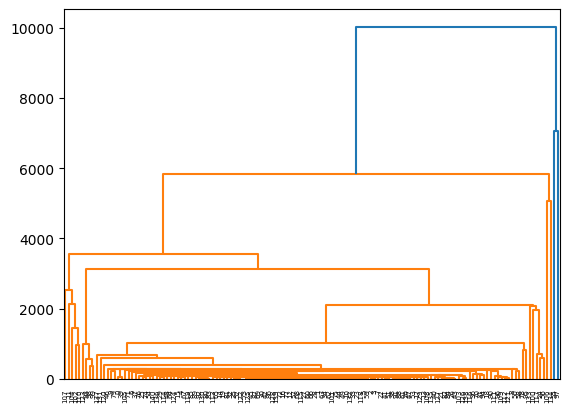

Complete


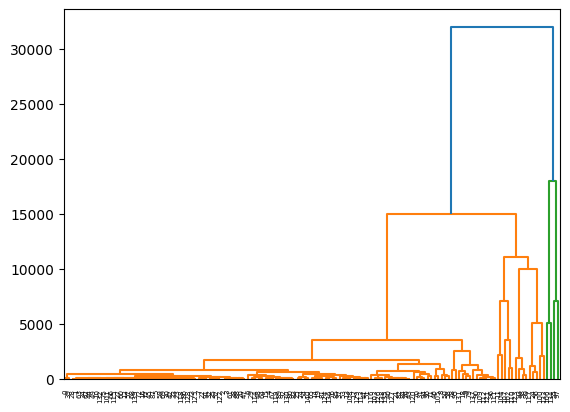

Average


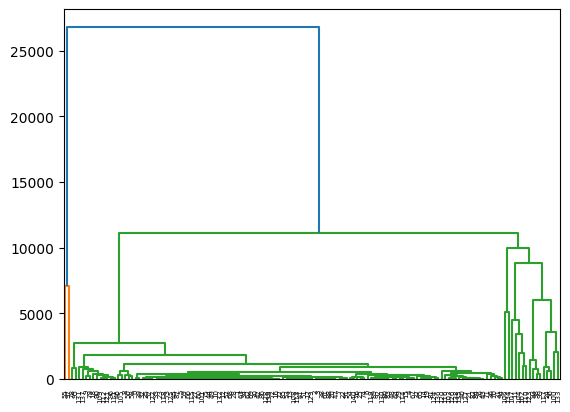

Ward


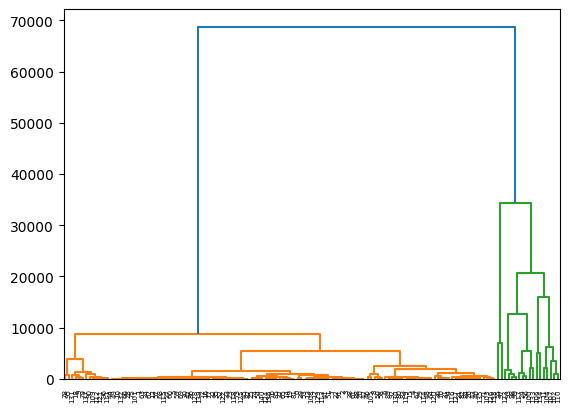

In [ ]:
print('Simple')
dendrogram(linkage_data1)
plt.show()
print('Complete')
dendrogram(linkage_data2)
plt.show()
print('Average')
dendrogram(linkage_data3)
plt.show()
print('Ward')
dendrogram(linkage_data4)
plt.show()

Puede observarse que 3 de los 4 métodos evaluados crean un cluster de apenas dos o tres proveedores y agrupa a los demás en una sola categoría. Esta forma de clasificación no resulta apropiada a largo plazo, por lo que el algoritmo a utilizar, en caso de seleccionarse el método jerárquico, es el algoritmo de Ward

### DBScan

Para realizar la parametrización del DBSCan primero se realizó un análisis exploratorio para encontrar las configuraciones de epsilon y mínimo de muestras que no clasificaran a todos los datos como outliers. Sobre dicha parametrización, se corrió un grid con las combinaciones posibles que maximizaran el coeficiente de Silhouette. Los resultados se presentan a continuación

In [ ]:

epsilon = [1,2,3,4,5,6,7,8,9,10]
min_samples = [1,2,3]


sil_avg = []
max_value = [0,0,0,0]

for i in range(len(epsilon)):
    for j in range(len(min_samples)):

        db = DBSCAN(min_samples = min_samples[j], eps =epsilon[i]).fit(X)
        #cluster_labels=dbscan.fit_predict(data)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)


        silhouette_avg = metrics.silhouette_score(X, labels)
        if silhouette_avg > max_value[3]:
            max_value=(epsilon[i], min_samples[j], n_clusters_, silhouette_avg)
        sil_avg.append(silhouette_avg)

print("epsilon=", max_value[0],
      "\nmin_sample=", max_value[1],
      "\nnumber of clusters=", max_value[2],
      "\naverage silhouette score= %.4f" % max_value[3])

epsilon= 8 
min_sample= 1 
number of clusters= 120 
average silhouette score= 0.1506


### GMM (Gaussian Mixture Model)

Para el modelo GMM, se parametrizó el número de componentes y se seleccionó la combinación que maximizara el coeficiente de Silhouette. Los resultados se muestran a continuación

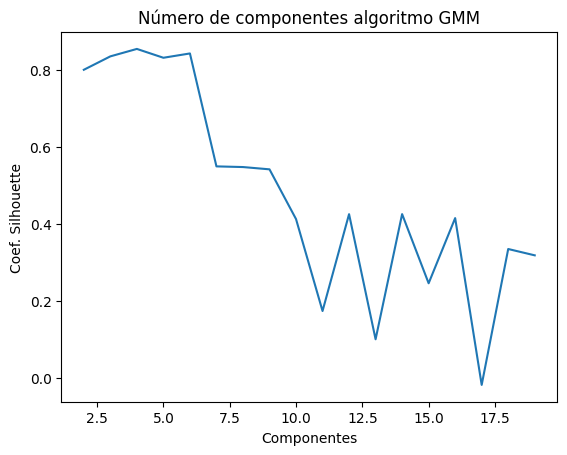

3


In [ ]:
componentes = range(2,20)
sil_GMM = []
for i in componentes:
  gaussian_model = GaussianMixture(n_components=i)
  gaussian_model.fit(X)
  gaussian_result = gaussian_model.predict(X)
  gaussian_clusters = np.unique(gaussian_result)
  sil_GMM.append(silhouette_score(X, gaussian_model.predict(X)))
plt.plot(componentes,sil_GMM)
plt.ylabel('Coef. Silhouette')
plt.xlabel('Componentes')
plt.title('Número de componentes algoritmo GMM')
plt.show()

# define the model
gaussian_modelF = GaussianMixture(n_components=3)

# train the model
gaussian_modelF.fit(X)

# assign each data point to a cluster
gaussian_resultF = gaussian_modelF.predict(X)
gaussian_clustersF = np.unique(gaussian_resultF)
sil_Gau = silhouette_score(X, gaussian_modelF.predict(X))


Puede observarse que el mayor valor del coeficiente de Silhouette se encuentra con tres componentes, y que el número de clusters óptimo para el método GMM es  de 3

### K-Medioids

Finalmente, para K-medioides se realiza un proceso similar al de GMM, iterando el número de clusters y revisando el valor que optimice el coeficiente de Silhouette

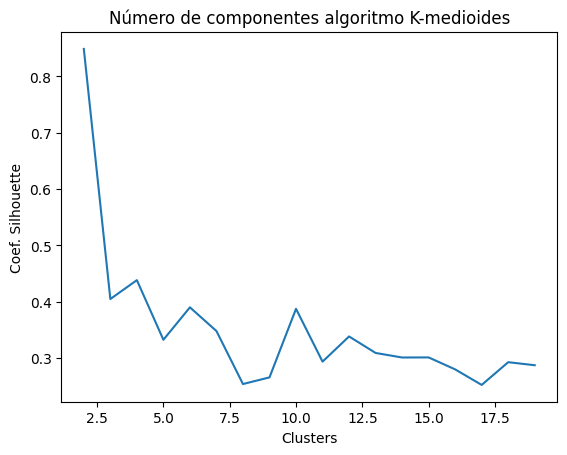

In [ ]:
componentes = range(2,20)
sil_KMed = []
for i in componentes:
  kmedoids = KMedoids(n_clusters=i, random_state=0).fit(X)
  sil_KMed.append(silhouette_score(X, kmedoids.predict(X)))
plt.plot(componentes,sil_KMed)
plt.ylabel('Coef. Silhouette')
plt.xlabel('Clusters')
plt.title('Número de componentes algoritmo K-medioides')
plt.show()

kmedoidsF = KMedoids(n_clusters=2, random_state=0).fit(X)
sil_KMedF = silhouette_score(X, kmedoidsF.predict(X))


Puede observarse que el valor de clusters que maximiza el coeficiente de Silhouette es de 2 coeficientes

## Análisis de alternativas y ajustes requeridos

La siguiente tabla muestra el resumen del coeficiente de Silhouette para cada una de las metodologías obtenidas, así como el número de clusters

In [ ]:
data = [['K-means', sil_kmeans, 5],
['Jerárquico (Ward)', sil_4, 2],
['DBScan', max_value[3], 120],
['GMM', sil_Gau, 3],
['K-Medioids', sil_KMedF, 2]]

print (tabulate(data, headers=["Método", "Coef. Silhouette", "Clusters"]))

Método               Coef. Silhouette    Clusters
-----------------  ------------------  ----------
K-means                      0.862392           5
Jerárquico (Ward)            0.840099           2
DBScan                       0.15057          120
GMM                          0.851359           3
K-Medioids                   0.84893            2


Puede observarse que el método menos conveniente para la creación de grupos es DBScan, ya que presenta alta superposición de clusters y suele clasificar a múltiples proveedores como su propio grupo. De los demás métodos, el método que posee tanto el mayor coeficiente de Silhouette, como una clasificación más diversa de clusters es el método de K-means, por lo que será usado para la clasificación y agrupamiento de proveedores.

Para esta primera etapa, se contempla aumentar la completitud del campo de diferencia de precios frente al SIPSA, ya que la agrupación puede llegar a verse alterada por la presencia de dichos valores de cero estimados. También es importante incluir dentro del prototipo una categorización de cada uno de los clusters en función de tamaño y características, para entender con el usuario final la claridad de la clasificación y la posibilidad de evaluar la adición o remoción de variables.

## Componentes y artefactos pendientes de implementación